In [27]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras
import requests
import zipfile
import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

URL_DATASET = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

#data set /content/dataset/PetImages/Dog e /content/dataset/PetImages/Cat

In [3]:
def downloadDataset():
    # Check if the dataset already exists
    if os.path.exists('/content/dataset/PetImages/Dog') and os.path.exists('/content/dataset/PetImages/Cat'):
        print("Dataset already exists. Skipping download.")
        return

    try:
        print("Downloading dataset...")
        response = requests.get(URL_DATASET, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            print("Extracting dataset...")
            zip_ref.extractall('/content/dataset')

        print("Dataset downloaded and extracted successfully!")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading dataset: {e}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting dataset: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [4]:
downloadDataset()

Dataset already exists. Skipping download.


In [13]:
# Função para carregar o dataset
def load_dataset(dataset_path, max_images_per_category=1000):
    data = []
    categories = ['Dog', 'Cat']  # Pastas no dataset
    image_size = (224, 224)  # Dimensão das imagens

    # Iterar por cada categoria
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"Directory {category_path} does not exist!")
            continue

        print(f"Loading images for category: {category}")
        image_count = 0  # Contador de imagens carregadas

        for img_file in os.listdir(category_path):
            if image_count >= max_images_per_category:
                break  # Parar ao atingir o limite de imagens

            img_path = os.path.join(category_path, img_file)

            try:
                # Ignorar arquivos que não são imagens
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                # Verificar integridade da imagem
                with Image.open(img_path) as img:
                    img.verify()  # Verifica a integridade do arquivo

                # Carregar e pré-processar a imagem
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0  # Normalização para [0, 1]
                data.append({'x': img_array, 'y': label})
                image_count += 1
            except Exception as e:
                print(f"Error processing file {img_path}: {e}")

        print(f"Loaded {image_count} images for category: {category}")

    # Embaralhar os dados
    random.shuffle(data)
    print(f"Total images loaded: {len(data)}")
    return data

# Caminho do dataset
dataset_path = '/content/dataset/PetImages'

# Carregar o dataset
data = load_dataset(dataset_path)

# Separar as imagens e labels
x = np.array([t['x'] for t in data])
y = np.array([t['y'] for t in data])

# Verificar shapes
print("Shape of X:", x.shape)
print("Shape of Y:", y.shape)

Loading images for category: Dog
Loaded 1000 images for category: Dog
Loading images for category: Cat
Error processing file /content/dataset/PetImages/Cat/666.jpg: cannot identify image file '/content/dataset/PetImages/Cat/666.jpg'
Loaded 1000 images for category: Cat
Total images loaded: 2000
Shape of X: (2000, 224, 224, 3)
Shape of Y: (2000,)


In [16]:
# Definir as proporções de cada conjunto
train_split = 0.7  # 70% para treinamento
val_split = 0.15   # 15% para validação
test_split = 0.15  # 15% para teste

# Dividir os dados
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

# Criar os conjuntos
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# Verificar o tamanho de cada conjunto
print(f"Train/Val/Test split: {len(train)}, {len(val)}, {len(test)}")


Train/Val/Test split: 1400, 300, 300


In [18]:
from keras.utils import to_categorical

# Separar as imagens e labels para treinamento, validação e teste
x_train = np.array([item['x'] for item in train])
y_train = np.array([item['y'] for item in train])

x_val = np.array([item['x'] for item in val])
y_val = np.array([item['y'] for item in val])

x_test = np.array([item['x'] for item in test])
y_test = np.array([item['y'] for item in test])

# Verificar as shapes dos dados
print(f"Shape dos dados de treinamento: {x_train.shape}")
print(f"Shape das labels de treinamento: {y_train.shape}")
print(f"Shape dos dados de validação: {x_val.shape}")
print(f"Shape das labels de validação: {y_val.shape}")
print(f"Shape dos dados de teste: {x_test.shape}")
print(f"Shape das labels de teste: {y_test.shape}")

# Converter as labels para one-hot encoding
y_train = to_categorical(y_train, num_classes=2)  # Ajuste 'num_classes' conforme necessário
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Verificar as shapes após a conversão
print(f"Shape das labels de treinamento após one-hot encoding: {y_train.shape}")
print(f"Shape das labels de validação após one-hot encoding: {y_val.shape}")
print(f"Shape das labels de teste após one-hot encoding: {y_test.shape}")


Shape dos dados de treinamento: (1400, 224, 224, 3)
Shape das labels de treinamento: (1400,)
Shape dos dados de validação: (300, 224, 224, 3)
Shape das labels de validação: (300,)
Shape dos dados de teste: (300, 224, 224, 3)
Shape das labels de teste: (300,)
Shape das labels de treinamento após one-hot encoding: (1400, 2)
Shape das labels de validação após one-hot encoding: (300, 2)
Shape das labels de teste após one-hot encoding: (300, 2)


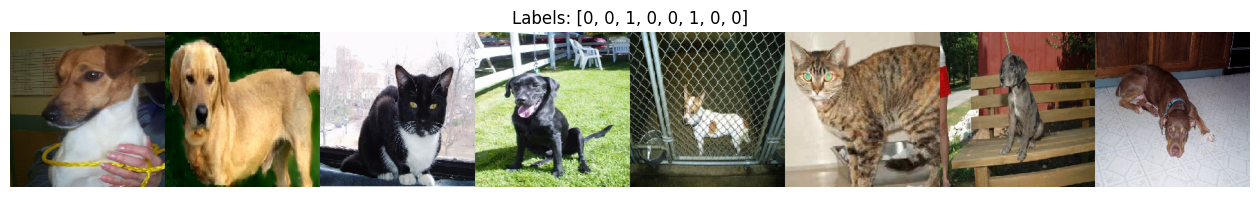

In [24]:
# Selecionar aleatoriamente 8 imagens do dataset
idx = [int(len(data) * random.random()) for _ in range(8)]  # Gerar 8 índices aleatórios

# Carregar as imagens e seus rótulos
imgs = [data[i]['x'] for i in idx]  # Lista com as 8 imagens selecionadas
labels = [data[i]['y'] for i in idx]  # Rótulos (labels) correspondentes

# Converter as imagens de volta para formato de imagem (para exibição)
imgs = [array_to_img(img) for img in imgs]

# Concatenar as imagens para exibição
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

# Plotar a imagem concatenada
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)
plt.title(f"Labels: {labels}")  # Opcional: Exibir rótulos das imagens
plt.axis('off')  # Desligar o eixo
plt.show()

In [28]:
# Build the network
model = Sequential()
model.add(Input(shape=(224, 224, 3)))  # Usando Input ao invés de input_shape para a primeira camada

# Primeiras camadas convolucionais
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

# Camadas densas
model.add(Flatten())  # Achatar para passar para as camadas densas
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(num_classes))
model.add(Activation('softmax'))  # Para classificação multi-classe

model.summary()  # Resumo do modelo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4659 - loss: 0.7328 - val_accuracy: 0.5267 - val_loss: 0.6953
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.4814 - loss: 0.7240 - val_accuracy: 0.5267 - val_loss: 0.6946
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.4839 - loss: 0.7192 - val_accuracy: 0.5267 - val_loss: 0.6940
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4717 - loss: 0.7286 - val_accuracy: 0.5267 - val_loss: 0.6936
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.4881 - loss: 0.7127 - val_accuracy: 0.5267 - val_loss: 0.6933
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.4889 - loss: 0.7090 - val_accuracy: 0.5267 - val_loss: 0.6930
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4926 - loss: 0.7109 - val_accuracy: 0.5167 - val_loss: 0.6929
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5021 - loss: 0.7063 - val_accuracy: 0.50

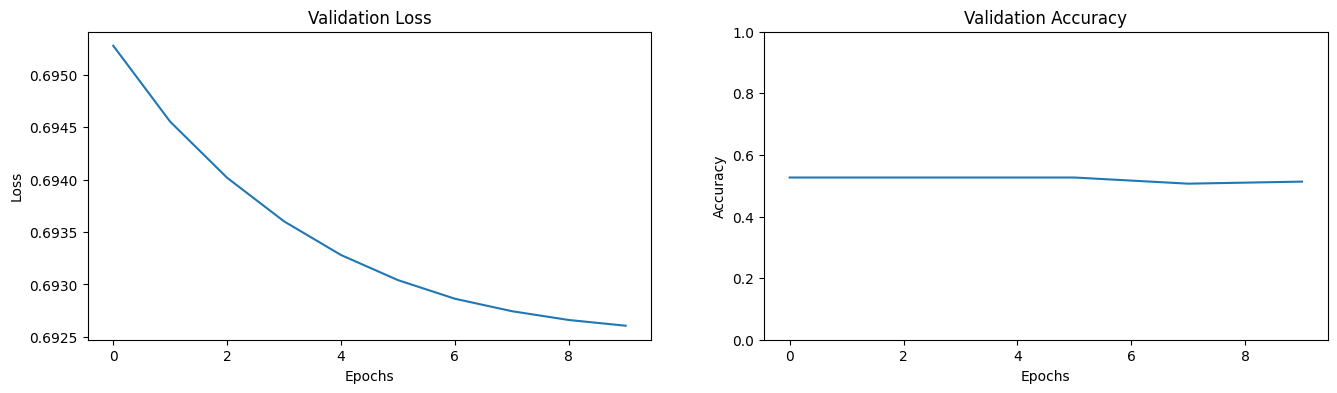

In [31]:
fig = plt.figure(figsize=(16, 4))

# Subplot para o gráfico de "validation loss"
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

# Subplot para o gráfico de "validation accuracy"
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])  # Corrigido para "val_accuracy"
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)

plt.show()

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.692596435546875
Test accuracy: 0.5400000214576721


In [33]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [35]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [36]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.5048 - loss: 1.0314 - val_accuracy: 0.5733 - val_loss: 0.6489
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 703ms/step - accuracy: 0.5634 - loss: 0.6811 - val_accuracy: 0.6733 - val_loss: 0.5661
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 829ms/step - accuracy: 0.6844 - loss: 0.5555 - val_accuracy: 0.8233 - val_loss: 0.4908
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 733ms/step - accuracy: 0.8307 - loss: 0.4630 - val_accuracy: 0.8333 - val_loss: 0.4572
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 753ms/step - accuracy: 0.8187 - loss: 0.4384 - val_accuracy: 0.8433 - val_loss: 0.4073
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 754ms/step - accuracy: 0.8486 - loss: 0.4032 - val_accuracy: 0.8300 - val_loss: 0.3925
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 737ms/step - accuracy: 0.8404 - loss: 0.3841 - val_accuracy: 0.8533 - val_loss: 0.3717
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 732ms/step - accuracy: 0.8665 - loss: 0.3672 - val_accuracy

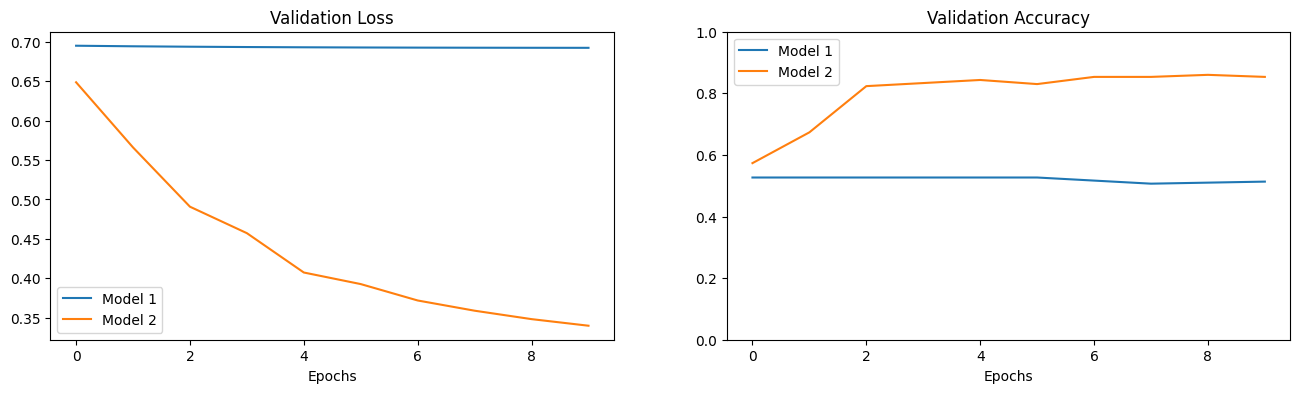

In [37]:
fig = plt.figure(figsize=(16,4))

# Gráfico da perda de validação
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Model 1")
ax.plot(history2.history["val_loss"], label="Model 2")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()

# Gráfico da acurácia de validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Model 1")
ax2.plot(history2.history["val_accuracy"], label="Model 2")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()


In [38]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3578674793243408
Test accuracy: 0.8600000143051147


In [43]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


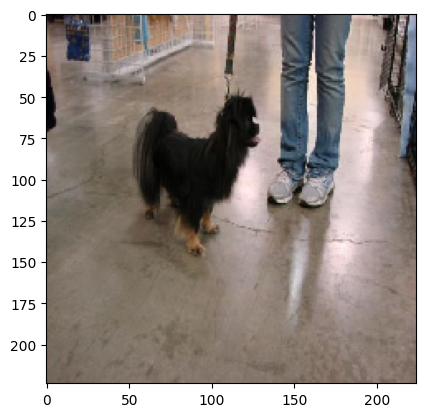

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilidades para cada classe: [[1.0000000e+00 1.3232104e-09]]
Classe predita: 0


In [47]:
# Caminho da nova imagem
img_path = '/content/dataset/PetImages/Dog/1000.jpg'

# Carregar a imagem e pré-processá-la
img, x = get_image(img_path)

# Obter as probabilidades para cada classe
probabilities = model_new.predict(x)

# Mostrar as probabilidades das classes
print("Probabilidades para cada classe:", probabilities)

# Para visualizar qual classe o modelo previu com maior probabilidade
predicted_class = np.argmax(probabilities)
print("Classe predita:", predicted_class)
